# Prenatal care and death rate

Exploring relationships between prenatal care, infant death rate, and gestational age

In [1]:
import warnings

import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
import statsmodels.api as sm

warnings.filterwarnings('ignore')
norm = colors.Normalize(vmin=28, vmax=40)
viridis = cm.ScalarMappable(norm=norm, cmap='viridis')

In [2]:
def filter_values(row):
    if row.isna().any():
        return True
    if 'Unreliable' in row['Death Rate']:
        return True
    if 'Not Applicable' in row['Death Rate']:
        return True
    if float(row['Births']) == 0.0:
        return True
    return False

def get_prenatal(row):
    return row['Month Prenatal Care Began Code'] != 0

prenatal = pd.read_csv('../data/CDC/death_rate.txt', sep='\t')
prenatal.drop(columns=['Notes', 'Year of Death Code'], inplace=True)
prenatal['Drop'] = prenatal.apply(filter_values, axis=1)
prenatal = prenatal[prenatal['Drop'] == False].drop(columns='Drop')
prenatal['Prenatal Care'] = prenatal.apply(get_prenatal, axis=1)
prenatal = prenatal.astype({
    'Month Prenatal Care Began Code': int,
    'Year of Death': int,
    'OE Gestational Age Weekly Code': int,
    'Deaths': int,
    'Births': int,
    'Death Rate': float
})

subset = prenatal[(prenatal['Year of Death'] >= 2016) &
                  (prenatal['OE Gestational Age Weekly Code'] >= 28) &
                  (prenatal['OE Gestational Age Weekly Code'] <= 40)]

## Is there a difference between death rate with or without prenatal care?

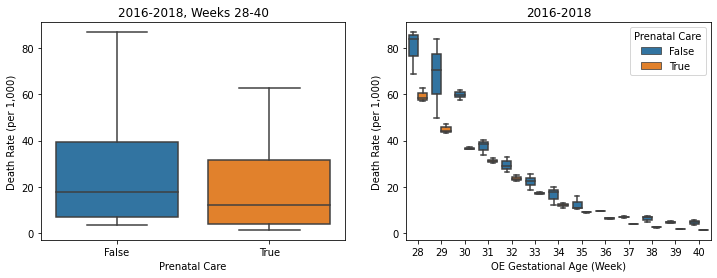

In [3]:
df1 = subset.groupby(['Year of Death', 'OE Gestational Age Weekly Code', 'Prenatal Care'])[['Deaths', 'Births']].sum()
df1['Death Rate'] = df1.apply(lambda row: 1000*row['Deaths']/row['Births'], axis=1)

year_list = []
week_list = []
care_list = []
rate_list = []
log_list = []
for idx, row in df1.iterrows():
    year_list.append(row.name[0])
    week_list.append(row.name[1])
    care_list.append(row.name[2])
    rate_list.append(row['Death Rate'])
    log_list.append(np.log(row['Death Rate']))
df2 = pd.DataFrame(data={
    'Year of Death': year_list,
    'Gestational Week': week_list,
    'Prenatal Care': care_list,
    'Death Rate': rate_list,
    'Log Death Rate': log_list
})

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(x='Prenatal Care', y='Death Rate', data=df2, ax=ax[0])
ax[0].set_ylabel('Death Rate (per 1,000)')
ax[0].set_title('2016-2018, Weeks 28-40')

sns.boxplot(x='Gestational Week', y='Death Rate', hue='Prenatal Care', data=df2, ax=ax[1])
ax[1].set_xlabel('OE Gestational Age (Week)')
ax[1].set_ylabel('Death Rate (per 1,000)')
ax[1].set_title('2016-2018')
plt.savefig('../results/death_rate_1.png', dpi=300)

In [4]:
care = df2[df2['Prenatal Care'] == True]
nocare = df2[df2['Prenatal Care'] == False]
print('00', ttest_ind(care['Death Rate'], nocare['Death Rate'], equal_var=False))

for week in df2['Gestational Week'].unique():
    care_sub = care[care['Gestational Week'] == week]
    nocare_sub = nocare[nocare['Gestational Week'] == week]
    print(week, ttest_ind(care_sub['Death Rate'], nocare_sub['Death Rate'], equal_var=False))

00 Ttest_indResult(statistic=-1.642513407404807, pvalue=0.10508074756888475)
28 Ttest_indResult(statistic=-3.5153728303794782, pvalue=0.05706447234131508)
29 Ttest_indResult(statistic=-2.315651657692109, pvalue=0.14303324611943566)
30 Ttest_indResult(statistic=-17.987930317275627, pvalue=0.001972274135507468)
31 Ttest_indResult(statistic=-3.171805845787724, pvalue=0.06930258636576016)
32 Ttest_indResult(statistic=-2.711004983783278, pvalue=0.08787047913385787)
33 Ttest_indResult(statistic=-2.559521664343243, pvalue=0.11911444242907021)
34 Ttest_indResult(statistic=-1.844365680925128, pvalue=0.19235037151872958)
35 Ttest_indResult(statistic=-1.983934300123483, pvalue=0.18501869381253916)
36 Ttest_indResult(statistic=-19.89659148734449, pvalue=0.0003558192903035291)
37 Ttest_indResult(statistic=-14.187619541322048, pvalue=0.0014186286744101468)
38 Ttest_indResult(statistic=-4.253678169123892, pvalue=0.049291080010867794)
39 Ttest_indResult(statistic=-12.525258857874634, pvalue=0.00574677

## Can we fit a model to the data above?

In [5]:
df_f = df2[df2['Prenatal Care'] == False]
model_f = sm.OLS(df_f['Log Death Rate'], sm.add_constant(df_f['Gestational Week']))
res_f = model_f.fit()
print(res_f.summary())

                            OLS Regression Results                            
Dep. Variable:         Log Death Rate   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     1187.
Date:                Mon, 18 Oct 2021   Prob (F-statistic):           1.03e-29
Time:                        20:54:43   Log-Likelihood:                 13.326
No. Observations:                  39   AIC:                            -22.65
Df Residuals:                      37   BIC:                            -19.33
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               11.7041      0.258  

In [6]:
df_t = df2[df2['Prenatal Care'] == True]
model_t = sm.OLS(df_t['Log Death Rate'], sm.add_constant(df_t['Gestational Week']))
res_t = model_t.fit()
print(res_t.summary())

                            OLS Regression Results                            
Dep. Variable:         Log Death Rate   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     2487.
Date:                Mon, 18 Oct 2021   Prob (F-statistic):           1.56e-35
Time:                        20:54:43   Log-Likelihood:                 19.267
No. Observations:                  39   AIC:                            -34.53
Df Residuals:                      37   BIC:                            -31.21
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               13.3574      0.222  

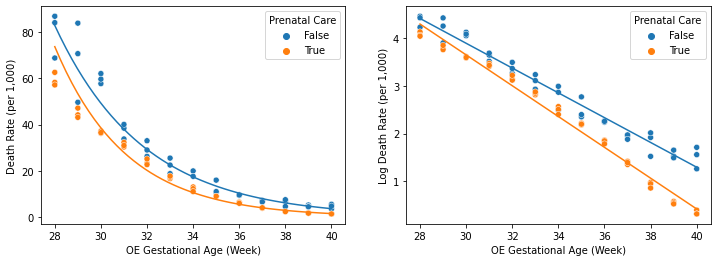

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.scatterplot(x='Gestational Week', y='Death Rate', hue='Prenatal Care', data=df2, ax=ax[0])
sns.scatterplot(x='Gestational Week', y='Log Death Rate', hue='Prenatal Care', data=df2, ax=ax[1])

x = np.linspace(28, 40)
y_f = np.polyval([res_f.params[1], res_f.params[0]], x)
ax[0].plot(x, np.exp(y_f))
ax[1].plot(x, y_f)

y_t = np.polyval([res_t.params[1], res_t.params[0]], x)
ax[0].plot(x, np.exp(y_t))
ax[1].plot(x, y_t)

ax[0].set_xlabel('OE Gestational Age (Week)')
ax[1].set_xlabel('OE Gestational Age (Week)')
ax[0].set_ylabel('Death Rate (per 1,000)')
ax[1].set_ylabel('Log Death Rate (per 1,000)')
plt.savefig('../results/death_rate_2.png', dpi=300)

## Does the month you start prenatal care matter?

In [8]:
df = subset[subset['Prenatal Care'] == True]
df['Log Death Rate'] = df.apply(lambda row: np.log(row['Death Rate']), axis=1)
model_me = sm.MixedLM(df['Log Death Rate'].values,                 # dependent variable
                      df['Month Prenatal Care Began Code'].values, # fixed effects covariates
                      df['OE Gestational Age Weekly Code'].values) # groups
res_me = model_me.fit()
print(res_me.summary())

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: y      
No. Observations: 266     Method:             REML   
No. Groups:       13      Scale:              0.0337 
Min. group size:  13      Log-Likelihood:     16.9258
Max. group size:  27      Converged:          Yes    
Mean group size:  20.5                               
-----------------------------------------------------
            Coef. Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------
x1          0.139    0.005 26.021 0.000  0.129  0.150
Group Var   5.505   12.063                           



In [9]:
# Fixed effects parameters
res_me.params

array([1.39145985e-01, 1.63172432e+02])

In [10]:
# Random effects parameterse
res_me.random_effects

{28: Group Var    3.699516
 dtype: float64,
 29: Group Var    3.40878
 dtype: float64,
 30: Group Var    3.256134
 dtype: float64,
 31: Group Var    3.093056
 dtype: float64,
 32: Group Var    2.837954
 dtype: float64,
 33: Group Var    2.51476
 dtype: float64,
 34: Group Var    2.180469
 dtype: float64,
 35: Group Var    1.809666
 dtype: float64,
 36: Group Var    1.482903
 dtype: float64,
 37: Group Var    1.058877
 dtype: float64,
 38: Group Var    0.567792
 dtype: float64,
 39: Group Var    0.207142
 dtype: float64,
 40: Group Var   -0.027362
 dtype: float64}

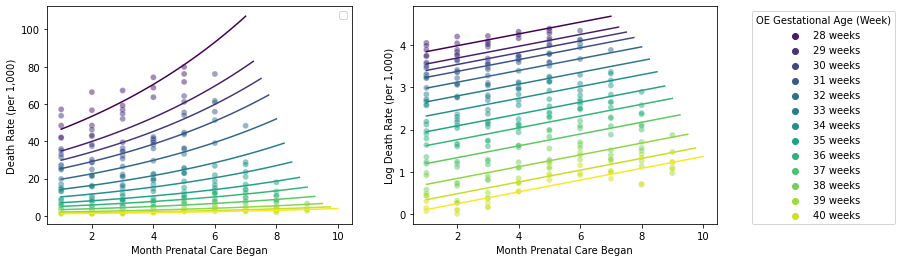

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.scatterplot(x='Month Prenatal Care Began Code', y='Death Rate', hue='OE Gestational Age Weekly',
                palette='viridis', data=df, ax=ax[0], alpha=0.5)
sns.scatterplot(x='Month Prenatal Care Began Code', y='Log Death Rate', hue='OE Gestational Age Weekly',
                palette='viridis', data=df, ax=ax[1], alpha=0.5)

for week in df['OE Gestational Age Weekly Code'].unique():
    x = np.linspace(1, week/4)
    y = res_me.random_effects[week][0] + res_me.params[0]*x
    ax[0].plot(x, np.exp(y), c=viridis.to_rgba(week))
    ax[1].plot(x, y, c=viridis.to_rgba(week))
    
ax[0].set_xlabel('Month Prenatal Care Began')
ax[1].set_xlabel('Month Prenatal Care Began')
ax[0].set_ylabel('Death Rate (per 1,000)')
ax[1].set_ylabel('Log Death Rate (per 1,000)')
ax[0].legend('')
ax[1].legend(title='OE Gestational Age (Week)', bbox_to_anchor=(1.6, 1))
plt.savefig('../results/death_rate_3.png', dpi=300)